# Notebook 17: Cross-Asset Generalization Test (All Horizons)

**Objective**: Test if a model trained on one asset can generalize to predict another asset.

**Experiment**:
- Train LSTM Attention model on AMZN data
- Test the trained model on AAPL data
- Compare performance across ALL horizons (1day, 1week, 1month)

---

## 1. Setup and Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, Layer, Bidirectional, BatchNormalization
)
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import pickle
import os
import sys
from datetime import datetime

sys.path.append('../utils')
import utils

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print("[OK] Libraries imported")

TensorFlow version: 2.19.1
[OK] Libraries imported


In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

SEQUENCES_DIR = '../data_new/sequences/'
MODELS_DIR = '../models/cross_asset/'
FIGURES_DIR = '../results/figures/cross_asset/'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# EXPERIMENT CONFIGURATION
TRAIN_ASSET = 'AMZN'
TEST_ASSET = 'AAPL'
HORIZONS = ['1day', '1week', '1month']  # All horizons

print("[OK] Configuration set")
print(f"\nExperiment: Train on {TRAIN_ASSET}, Test on {TEST_ASSET}")
print(f"Horizons to test: {HORIZONS}")

[OK] Configuration set

Experiment: Train on AMZN, Test on AAPL
Horizons to test: ['1day', '1week', '1month']


## 2. Model Components

In [3]:
class AttentionLayer(Layer):
    def __init__(self, return_attention=False, **kwargs):
        self.return_attention = return_attention
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = K.sum(inputs * alpha, axis=1)
        return context
    
    def get_config(self):
        config = super().get_config()
        config.update({'return_attention': self.return_attention})
        return config

def build_model(seq_len, n_feat, lstm_units=64, lstm_layers=2, dropout=0.4, dense_units=32, lr=0.001):
    inputs = Input(shape=(seq_len, n_feat))
    x = inputs
    for i in range(lstm_layers):
        x = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
    x = AttentionLayer()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

print("[OK] Model components defined")

[OK] Model components defined


## 3. Run Cross-Asset Experiment for All Horizons

In [4]:
class_weights = utils.load_class_weights(SEQUENCES_DIR)

all_results = []

for horizon in HORIZONS:
    print(f"\n{'='*80}")
    print(f"HORIZON: {horizon}")
    print(f"Training on {TRAIN_ASSET}, Testing on {TEST_ASSET}")
    print(f"{'='*80}")
    
    # Load training data
    X_train, X_val, X_test_within, y_train, y_val, y_test_within, seq_len, n_feat = utils.load_sequences(
        TRAIN_ASSET, horizon, SEQUENCES_DIR
    )
    print(f"\n[{TRAIN_ASSET}] Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test_within.shape[0]}")
    
    # Load cross-asset test data
    _, _, X_test_cross, _, _, y_test_cross, _, _ = utils.load_sequences(
        TEST_ASSET, horizon, SEQUENCES_DIR
    )
    print(f"[{TEST_ASSET}] Test: {X_test_cross.shape[0]}")
    
    # Build and train model
    K.clear_session()
    model = build_model(seq_len, n_feat)
    
    cw = class_weights[TRAIN_ASSET][horizon]
    class_weight_dict = {0: cw[0], 1: cw[1]}
    
    model_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=0)
    ]
    
    print(f"\nTraining...")
    start = datetime.now()
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=model_callbacks,
        verbose=0
    )
    
    train_time = (datetime.now() - start).total_seconds()
    print(f"Training completed in {train_time:.1f}s ({len(history.history['loss'])} epochs)")
    
    # Evaluate within-asset
    y_pred_within = (model.predict(X_test_within, verbose=0) > 0.5).astype(int).flatten()
    y_proba_within = model.predict(X_test_within, verbose=0).flatten()
    
    within_metrics = {
        'Horizon': horizon,
        'Test Type': 'Within-Asset',
        'Train Asset': TRAIN_ASSET,
        'Test Asset': TRAIN_ASSET,
        'Accuracy': accuracy_score(y_test_within, y_pred_within),
        'Precision': precision_score(y_test_within, y_pred_within, zero_division=0),
        'Recall': recall_score(y_test_within, y_pred_within, zero_division=0),
        'F1': f1_score(y_test_within, y_pred_within, zero_division=0),
        'AUC': roc_auc_score(y_test_within, y_proba_within)
    }
    all_results.append(within_metrics)
    
    print(f"\nWithin-Asset ({TRAIN_ASSET}): Acc={within_metrics['Accuracy']:.4f}, F1={within_metrics['F1']:.4f}, AUC={within_metrics['AUC']:.4f}")
    
    # Evaluate cross-asset
    y_pred_cross = (model.predict(X_test_cross, verbose=0) > 0.5).astype(int).flatten()
    y_proba_cross = model.predict(X_test_cross, verbose=0).flatten()
    
    cross_metrics = {
        'Horizon': horizon,
        'Test Type': 'Cross-Asset',
        'Train Asset': TRAIN_ASSET,
        'Test Asset': TEST_ASSET,
        'Accuracy': accuracy_score(y_test_cross, y_pred_cross),
        'Precision': precision_score(y_test_cross, y_pred_cross, zero_division=0),
        'Recall': recall_score(y_test_cross, y_pred_cross, zero_division=0),
        'F1': f1_score(y_test_cross, y_pred_cross, zero_division=0),
        'AUC': roc_auc_score(y_test_cross, y_proba_cross)
    }
    all_results.append(cross_metrics)
    
    print(f"Cross-Asset ({TEST_ASSET}): Acc={cross_metrics['Accuracy']:.4f}, F1={cross_metrics['F1']:.4f}, AUC={cross_metrics['AUC']:.4f}")
    
    # Save model
    model.save(f'{MODELS_DIR}cross_asset_{TRAIN_ASSET}_to_{TEST_ASSET}_{horizon}.keras')

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED")
print("="*80)


HORIZON: 1day
Training on AMZN, Testing on AAPL

[AMZN] Train: 4405, Val: 623, Test: 1254
[AAPL] Test: 1254


Training...
Training completed in 77.9s (37 epochs)

Within-Asset (AMZN): Acc=0.5255, F1=0.6725, AUC=0.5097
Cross-Asset (AAPL): Acc=0.5367, F1=0.6885, AUC=0.4722

HORIZON: 1week
Training on AMZN, Testing on AAPL

[AMZN] Train: 4382, Val: 600, Test: 1231
[AAPL] Test: 1231

Training...
Training completed in 145.1s (23 epochs)

Within-Asset (AMZN): Acc=0.5370, F1=0.6971, AUC=0.5183
Cross-Asset (AAPL): Acc=0.5589, F1=0.7132, AUC=0.4951

HORIZON: 1month
Training on AMZN, Testing on AAPL

[AMZN] Train: 4322, Val: 540, Test: 1171
[AAPL] Test: 1171

Training...
Training completed in 302.5s (16 epochs)

Within-Asset (AMZN): Acc=0.5952, F1=0.7463, AUC=0.5587
Cross-Asset (AAPL): Acc=0.6140, F1=0.7608, AUC=0.5334

ALL EXPERIMENTS COMPLETED


## 4. Results Summary

In [5]:
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("CROSS-ASSET GENERALIZATION RESULTS")
print(f"Training Asset: {TRAIN_ASSET} | Test Asset: {TEST_ASSET}")
print("="*80)
print()
print(results_df.to_string(index=False))

# Pivot for easier comparison
print("\n" + "="*80)
print("COMPARISON BY HORIZON")
print("="*80)

for horizon in HORIZONS:
    horizon_df = results_df[results_df['Horizon'] == horizon]
    within = horizon_df[horizon_df['Test Type'] == 'Within-Asset'].iloc[0]
    cross = horizon_df[horizon_df['Test Type'] == 'Cross-Asset'].iloc[0]
    
    print(f"\n{horizon}:")
    print(f"  Within-Asset ({TRAIN_ASSET}): Acc={within['Accuracy']:.4f}, F1={within['F1']:.4f}, AUC={within['AUC']:.4f}")
    print(f"  Cross-Asset  ({TEST_ASSET}):  Acc={cross['Accuracy']:.4f}, F1={cross['F1']:.4f}, AUC={cross['AUC']:.4f}")
    
    acc_drop = within['Accuracy'] - cross['Accuracy']
    f1_drop = within['F1'] - cross['F1']
    print(f"  --> Accuracy Drop: {acc_drop:.4f} ({acc_drop/within['Accuracy']*100:.1f}%)")
    print(f"  --> F1 Drop: {f1_drop:.4f} ({f1_drop/within['F1']*100:.1f}%)" if within['F1'] > 0 else "")


CROSS-ASSET GENERALIZATION RESULTS
Training Asset: AMZN | Test Asset: AAPL

Horizon    Test Type Train Asset Test Asset  Accuracy  Precision   Recall       F1      AUC
   1day Within-Asset        AMZN       AMZN  0.525518   0.521331 0.947287 0.672537 0.509745
   1day  Cross-Asset        AMZN       AAPL  0.536683   0.535446 0.963964 0.688472 0.472153
  1week Within-Asset        AMZN       AMZN  0.536962   0.535510 0.998478 0.697131 0.518297
  1week  Cross-Asset        AMZN       AAPL  0.558895   0.557391 0.989736 0.713154 0.495083
 1month Within-Asset        AMZN       AMZN  0.595218   0.595218 1.000000 0.746253 0.558681
 1month  Cross-Asset        AMZN       AAPL  0.614005   0.614005 1.000000 0.760847 0.533364

COMPARISON BY HORIZON

1day:
  Within-Asset (AMZN): Acc=0.5255, F1=0.6725, AUC=0.5097
  Cross-Asset  (AAPL):  Acc=0.5367, F1=0.6885, AUC=0.4722
  --> Accuracy Drop: -0.0112 (-2.1%)
  --> F1 Drop: -0.0159 (-2.4%)

1week:
  Within-Asset (AMZN): Acc=0.5370, F1=0.6971, AUC=0.5183
 

## 5. Visualization

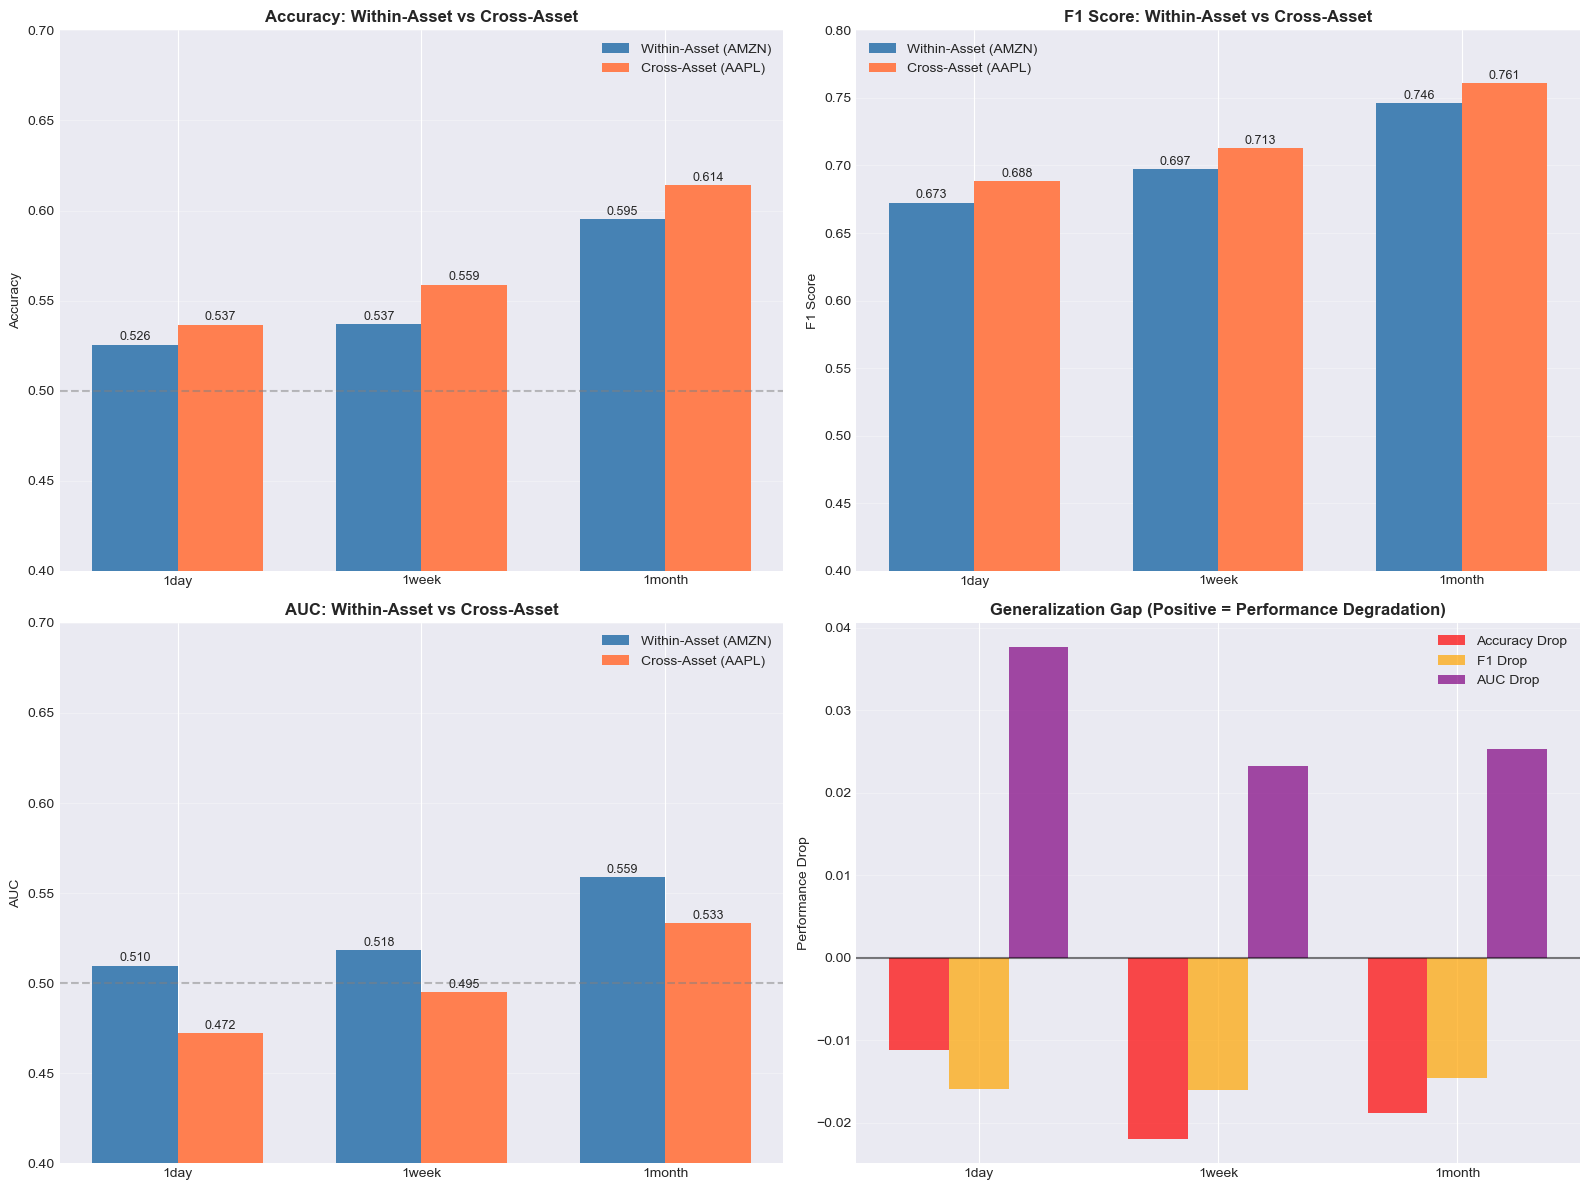

[OK] Figure saved


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
x = np.arange(len(HORIZONS))
width = 0.35

within_acc = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Within-Asset')]['Accuracy'].values[0] for h in HORIZONS]
cross_acc = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Cross-Asset')]['Accuracy'].values[0] for h in HORIZONS]

bars1 = ax1.bar(x - width/2, within_acc, width, label=f'Within-Asset ({TRAIN_ASSET})', color='steelblue')
bars2 = ax1.bar(x + width/2, cross_acc, width, label=f'Cross-Asset ({TEST_ASSET})', color='coral')

ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy: Within-Asset vs Cross-Asset', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(HORIZONS)
ax1.legend()
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax1.set_ylim(0.4, 0.7)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1 + bars2:
    ax1.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# 2. F1 comparison
ax2 = axes[0, 1]
within_f1 = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Within-Asset')]['F1'].values[0] for h in HORIZONS]
cross_f1 = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Cross-Asset')]['F1'].values[0] for h in HORIZONS]

bars3 = ax2.bar(x - width/2, within_f1, width, label=f'Within-Asset ({TRAIN_ASSET})', color='steelblue')
bars4 = ax2.bar(x + width/2, cross_f1, width, label=f'Cross-Asset ({TEST_ASSET})', color='coral')

ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score: Within-Asset vs Cross-Asset', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(HORIZONS)
ax2.legend()
ax2.set_ylim(0.4, 0.8)
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars3 + bars4:
    ax2.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# 3. AUC comparison
ax3 = axes[1, 0]
within_auc = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Within-Asset')]['AUC'].values[0] for h in HORIZONS]
cross_auc = [results_df[(results_df['Horizon']==h) & (results_df['Test Type']=='Cross-Asset')]['AUC'].values[0] for h in HORIZONS]

bars5 = ax3.bar(x - width/2, within_auc, width, label=f'Within-Asset ({TRAIN_ASSET})', color='steelblue')
bars6 = ax3.bar(x + width/2, cross_auc, width, label=f'Cross-Asset ({TEST_ASSET})', color='coral')

ax3.set_ylabel('AUC')
ax3.set_title('AUC: Within-Asset vs Cross-Asset', fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(HORIZONS)
ax3.legend()
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax3.set_ylim(0.4, 0.7)
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars5 + bars6:
    ax3.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

# 4. Performance drop
ax4 = axes[1, 1]
acc_drops = [within_acc[i] - cross_acc[i] for i in range(len(HORIZONS))]
f1_drops = [within_f1[i] - cross_f1[i] for i in range(len(HORIZONS))]
auc_drops = [within_auc[i] - cross_auc[i] for i in range(len(HORIZONS))]

x_pos = np.arange(len(HORIZONS))
width = 0.25

ax4.bar(x_pos - width, acc_drops, width, label='Accuracy Drop', color='red', alpha=0.7)
ax4.bar(x_pos, f1_drops, width, label='F1 Drop', color='orange', alpha=0.7)
ax4.bar(x_pos + width, auc_drops, width, label='AUC Drop', color='purple', alpha=0.7)

ax4.set_ylabel('Performance Drop')
ax4.set_title('Generalization Gap (Positive = Performance Degradation)', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(HORIZONS)
ax4.legend()
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}cross_asset_{TRAIN_ASSET}_to_{TEST_ASSET}_all_horizons.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Figure saved")

## 6. Conclusions

In [7]:
print("="*80)
print("CROSS-ASSET GENERALIZATION - FINAL CONCLUSIONS")
print("="*80)
print(f"\nExperiment: {TRAIN_ASSET} -> {TEST_ASSET}")

for horizon in HORIZONS:
    horizon_df = results_df[results_df['Horizon'] == horizon]
    within = horizon_df[horizon_df['Test Type'] == 'Within-Asset'].iloc[0]
    cross = horizon_df[horizon_df['Test Type'] == 'Cross-Asset'].iloc[0]
    
    acc_drop = within['Accuracy'] - cross['Accuracy']
    f1_drop = within['F1'] - cross['F1']
    
    if acc_drop < 0.05 and f1_drop < 0.05:
        quality = "EXCELLENT ✓"
    elif acc_drop < 0.10 and f1_drop < 0.10:
        quality = "GOOD ✓"
    elif acc_drop < 0.15:
        quality = "MODERATE ~"
    else:
        quality = "POOR ✗"
    
    print(f"\n{horizon}: {quality}")
    print(f"  Drop: Acc={acc_drop:.4f}, F1={f1_drop:.4f}")

# Save results
results_df.to_csv(f'{FIGURES_DIR}cross_asset_{TRAIN_ASSET}_to_{TEST_ASSET}_all_horizons.csv', index=False)
print(f"\n[OK] Results saved to CSV")
print("="*80)

CROSS-ASSET GENERALIZATION - FINAL CONCLUSIONS

Experiment: AMZN -> AAPL

1day: EXCELLENT ✓
  Drop: Acc=-0.0112, F1=-0.0159

1week: EXCELLENT ✓
  Drop: Acc=-0.0219, F1=-0.0160

1month: EXCELLENT ✓
  Drop: Acc=-0.0188, F1=-0.0146

[OK] Results saved to CSV
